In [6]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
cond_inp = keras.Input(shape=(10,))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)

x = layers.Dense(16, activation="relu")(x)
cond = layers.Dense(16, activation="relu")(cond_inp)

x = layers.Add()([x, cond])

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model([encoder_inputs, cond_inp], [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_2 (Conv2D)              (None, 14, 14, 32)   320         ['input_7[0][0]']                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 7, 7, 64)     18496       ['conv2d_2[0][0]']               
                                                                                                  
 flatten_1 (Flatten)            (None, 3136)         0           ['conv2d_3[0][0]']               
                                                                                            

In [9]:
latent_inputs = keras.Input(shape=(latent_dim,))
cond_inp = keras.Input(shape=(10,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
cond = layers.Dense(7 * 7 * 64, activation="relu")(cond_inp)

x = layers.Add()([x, cond])

x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model([latent_inputs, cond_inp], decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 3136)         9408        ['input_9[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 3136)         34496       ['input_10[0][0]']               
                                                                                            

In [11]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        #tf.print(data)
        #print(data)
        x = data[0]
        y = data[1]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder([x,y])
            reconstruction = self.decoder([z,y])
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [12]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

mnist_labels = np.concatenate([y_train, y_test], axis=0)
mnist_labels = mnist_labels.astype("float32")
mnist_labels = tf.one_hot(mnist_labels, 10)

train_data = tf.data.Dataset.from_tensor_slices((mnist_digits,mnist_labels))
#train_data = train_data.map(lambda x,y: ((x,y),x))
train_data = train_data.shuffle(len(mnist_labels), reshuffle_each_iteration=True).batch(128)

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_data, epochs=30)

Epoch 1/30


2022-07-28 17:43:38.378642: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-07-28 17:43:38.799953: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201
2022-07-28 17:43:39.436833: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 17:43:39.437156: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 17:43:39.437177: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-07-28 17:43:39.437468: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-07-28 17:43:39.437505: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to

547/547 [==============================] - 5s 4ms/step - loss: 241.5448 - reconstruction_loss: 187.1290 - kl_loss: 1.1719
Epoch 2/30
547/547 [==============================] - 2s 4ms/step - loss: 145.6420 - reconstruction_loss: 138.3513 - kl_loss: 4.3375
Epoch 3/30
547/547 [==============================] - 2s 4ms/step - loss: 138.4494 - reconstruction_loss: 133.4990 - kl_loss: 4.4894
Epoch 4/30
547/547 [==============================] - 2s 4ms/step - loss: 137.0562 - reconstruction_loss: 132.1291 - kl_loss: 4.5042
Epoch 5/30
547/547 [==============================] - 2s 4ms/step - loss: 136.0085 - reconstruction_loss: 131.2474 - kl_loss: 4.5069
Epoch 6/30
547/547 [==============================] - 2s 4ms/step - loss: 135.1925 - reconstruction_loss: 130.7018 - kl_loss: 4.5250
Epoch 7/30
547/547 [==============================] - 2s 4ms/step - loss: 134.6063 - reconstruction_loss: 130.2957 - kl_loss: 4.5072
Epoch 8/30
547/547 [==============================] - 2s 4ms/step - loss: 134.46

In [16]:
import matplotlib.pyplot as plt

1/1 [==============================] - 0s 11ms/step


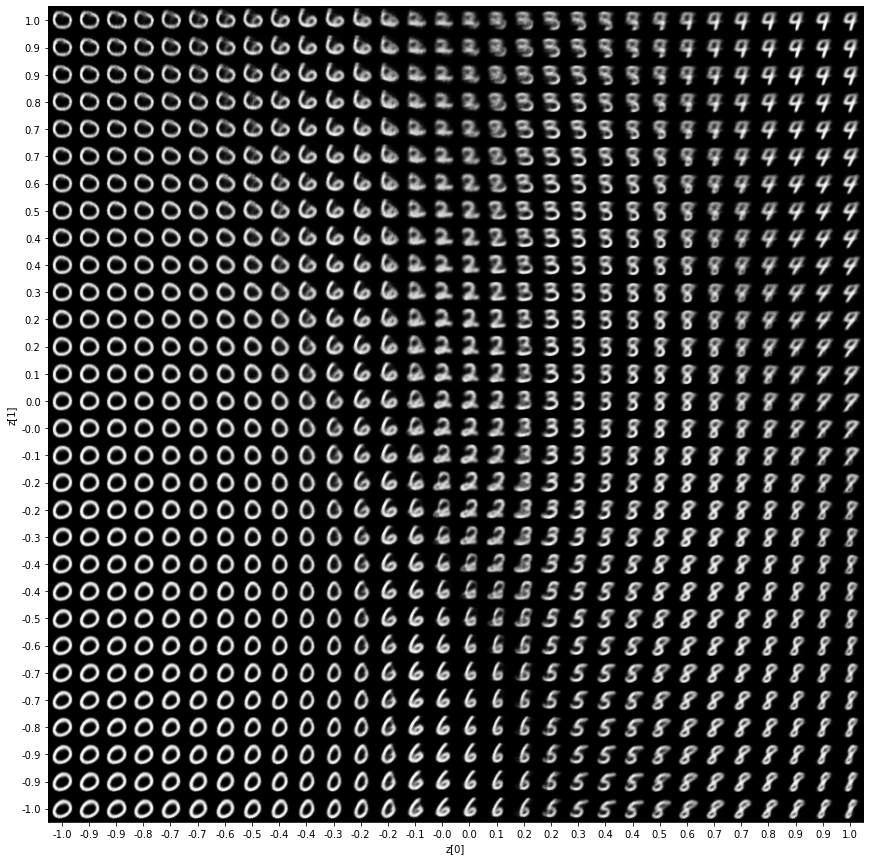

In [7]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

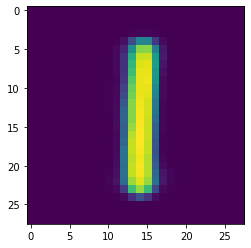

In [56]:
im = decoder([
    tf.random.normal([1,2]),
    tf.expand_dims(tf.one_hot(1, 10), 0)
])

plt.imshow(im[0])
plt.show()

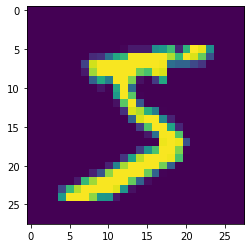

In [33]:
plt.imshow(mnist_digits[0])

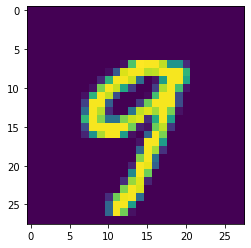

In [37]:
plt.imshow(mnist_digits[45])

In [38]:
m,ld,ep = encoder([
    tf.expand_dims(mnist_digits[0], 0), 
    tf.expand_dims(tf.one_hot(5, 10), 0)
])

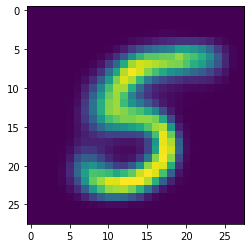

In [57]:
im = decoder([
    m,
    tf.expand_dims(tf.one_hot(5, 10), 0)
])

plt.imshow(im[0])
plt.show()